# Creating patches for PAIP challenge

To deal with the issue of analysing whole slide images, a common technique is to split the images up into patches which can be processed by deep learning models. I used a package called [py-wsi](https://github.com/ysbecca/py-wsi) to do this processing, but it required forking the project and implementing custom XML parsing logic to successfully read the files supplied for the challange. I can share that code if required but I wasn't sure how best to do it.

The below code requires the source dataset split into an SVS and XML folder, and the py-wsi library with the customised parsing logic. It will run with the built in parser logic but the labels will be all wrong.

In [ ]:
!apt-get install -y python-openslide
!pip install openslide-python


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 515, in _det

In [ ]:
import py_wsi
import py_wsi.imagepy_toolkit as tk
import os
import numpy as np

In [ ]:
%load_ext autoreload # Used for reloading the py-wsi library after edits
%autoreload 2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The paths below are specific to my Google Drive folder. It expects a directory with the following structure:

```
root/
    svs_folder/
        Pros_PNI2021chall_train_0018.svs
        Col_PNI2021chall_train_0020.svs
        Pan_PNI2021chall_train_0008.svs
        ...
    xml_folder/
        Pros_PNI2021chall_train_0018.xml
        Col_PNI2021chall_train_0020.xml
        Pan_PNI2021chall_train_0008.xml
        ...
    db_folder/
        # Processed data goes here, either hdf5 or PNG files generally
  

```



In [ ]:
root_directory = '/content/drive/MyDrive/ML/PAIP/data_copy'
svs_dir = f'{root_directory}/svs_folder/'
xml_dir = f'{root_directory}/xml_folder/'
db_location = f'{root_directory}/db_folder/'
db_name = 'paip_db'
patch_size = 64
overlap = 0
level = 12

# Required map to match the xml regions to a label
label_map = {'Normal': 0,
             'nerve without tumor': 1,
             'perineural invasion junction': 2,
             'tumor without nerve': 3,
             'nontumor without nerve': 4,
             '': 6
            }

In [ ]:
turtle = py_wsi.Turtle(svs_dir, db_location, db_name, xml_dir=xml_dir, label_map=label_map, storage_type='disk')


TESTING const
Storage type:               hdf5
Images directory:           /content/drive/MyDrive/ML/PAIP/data_copy/svs_folder/
Data store directory:       /content/drive/MyDrive/ML/PAIP/data_copy/db_folder/
Images found AHHHH:               150


In [ ]:
# Print some general information about the image file
# We can see the resolution for each level as well as the number of tiles that will be created in each dimension
# We picked level 12 as it is equivalent to level 2 if you open the SVS file with OpenSlide
level_count, level_tiles, level_dims = turtle.retrieve_tile_dimensions('Pros_PNI2021chall_train_0018.svs', patch_size=64)
print("Level count:         " + str(level_count))
print("Level tiles:         " + str(level_tiles))
print("Level dimensions:    " + str(level_dims))

list(zip(range(level_count), level_dims, level_tiles))


Setting patch size 64 and tile size 64
Level count:         17
Level tiles:         ((1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 2), (4, 3), (7, 6), (14, 11), (28, 22), (55, 43), (109, 86), (218, 171), (436, 342), (872, 683))
Level dimensions:    ((1, 1), (2, 2), (4, 3), (7, 6), (14, 11), (28, 22), (55, 43), (109, 86), (218, 171), (436, 342), (872, 683), (1743, 1365), (3486, 2729), (6972, 5458), (13944, 10916), (27888, 21832), (55775, 43663))


[(0, (1, 1), (1, 1)),
 (1, (2, 2), (1, 1)),
 (2, (4, 3), (1, 1)),
 (3, (7, 6), (1, 1)),
 (4, (14, 11), (1, 1)),
 (5, (28, 22), (1, 1)),
 (6, (55, 43), (1, 1)),
 (7, (109, 86), (2, 2)),
 (8, (218, 171), (4, 3)),
 (9, (436, 342), (7, 6)),
 (10, (872, 683), (14, 11)),
 (11, (1743, 1365), (28, 22)),
 (12, (3486, 2729), (55, 43)),
 (13, (6972, 5458), (109, 86)),
 (14, (13944, 10916), (218, 171)),
 (15, (27888, 21832), (436, 342)),
 (16, (55775, 43663), (872, 683))]

## Create and store patches

This code reads all the SVS files and creates patches in the desired format (PNG/disk or hdf5 files). This function references the XML file to read the labeled regions and see if the patch is contained within a label. It does not create a mask, just a label based on the center of the patch.

(If there is an error below it's because the below processing takes a very long time to run, so I processed all the patches on a different machine but used the code written here to do it. The function just lists out all the files it has processed.)

In [ ]:
turtle.sample_and_store_patches(patch_size, level, overlap, load_xml=True, limit_bounds=False)

Pan_PNI2021chall_train_0033.svs Pan_PNI2021chall_train_0034.svs 

KeyboardInterrupt: ignored

In [ ]:
# retrieve all the patches for a slide
patches, coords, classes, labels = turtle.get_patches_from_file("Pan_PNI2021chall_train_0033.svs", verbose=True)


[py-wsi] loaded from Pan_PNI2021chall_train_0033 .h5 file (2610, 64, 64, 3)


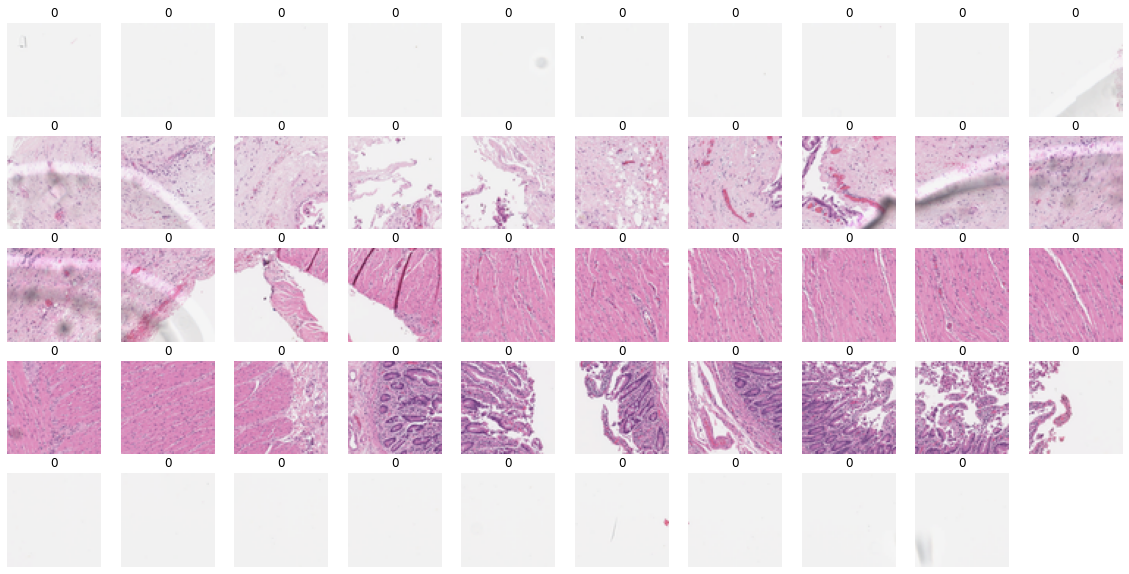

In [ ]:
# view some of the patches and their labels
tk.show_labeled_patches(patches[:50], classes[:50])